## Part I: Data Pre-processing

In [1]:
import pandas as pd

In [2]:
# Download the Google Analogy dataset
!wget http://download.tensorflow.org/data/questions-words.txt

--2025-09-20 09:29:54--  http://download.tensorflow.org/data/questions-words.txt
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.203.207, 74.125.199.207, 74.125.142.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.203.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 603955 (590K) [text/plain]
Saving to: ‘questions-words.txt’

questions-words.txt 100%[===================>] 589.80K  --.-KB/s    in 0.005s  

2025-09-20 09:29:54 (108 MB/s) - ‘questions-words.txt’ saved [603955/603955]



In [3]:
# Preprocess the dataset
file_name = "questions-words"
with open(f"{file_name}.txt", "r") as f:
    data = f.read().splitlines()

In [4]:
# check data from the first 10 entries
for entry in data[:10]:
    print(entry)

: capital-common-countries
Athens Greece Baghdad Iraq
Athens Greece Bangkok Thailand
Athens Greece Beijing China
Athens Greece Berlin Germany
Athens Greece Bern Switzerland
Athens Greece Cairo Egypt
Athens Greece Canberra Australia
Athens Greece Hanoi Vietnam
Athens Greece Havana Cuba


In [5]:
# TODO1: Write your code here for processing data to pd.DataFrame
# Please note that the first five mentions of ": " indicate `semantic`,
# and the remaining nine belong to the `syntatic` category.

In [6]:
questions, categories, sub_categories = [], [], []
current_subcat = None
subcat_order = []

for ln in data:  # 'data' is the list of lines you read from the file
    if ln.startswith(":"):
        current_subcat = ln[1:].strip()
        if current_subcat not in subcat_order:
            subcat_order.append(current_subcat)
        continue

    parts = ln.split()
    if len(parts) != 4 or current_subcat is None:
        continue

    a, b, c, d = parts
    questions.append(f"{a} {b} {c} {d}")
    categories.append("semantic" if subcat_order.index(current_subcat) < 5 else "syntactic")
    sub_categories.append(current_subcat)

In [7]:
# Create the dataframe
df = pd.DataFrame(
    {
        "Question": questions,
        "Category": categories,
        "SubCategory": sub_categories,
    }
)

In [8]:
df.head()

,Question,Category,SubCategory
0,Athens Greece Baghdad Iraq,semantic,capital-common-countries
1,Athens Greece Bangkok Thailand,semantic,capital-common-countries
2,Athens Greece Beijing China,semantic,capital-common-countries
3,Athens Greece Berlin Germany,semantic,capital-common-countries
4,Athens Greece Bern Switzerland,semantic,capital-common-countries


In [9]:
df.to_csv(f"{file_name}.csv", index=False)

## Part II: Use pre-trained word embeddings
- After finish Part I, you can run Part II code blocks only.

In [10]:
!pip install gensim

In [11]:
import pandas as pd
import numpy as np
import gensim.downloader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [12]:
data = pd.read_csv("questions-words.csv")

In [13]:
MODEL_NAME = "glove-wiki-gigaword-100"
# You can try other models.
# https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models

# Load the pre-trained model (using GloVe vectors here)
model = gensim.downloader.load(MODEL_NAME)
print("The Gensim model loaded successfully!")

[==================================================] 100.0% 128.1/128.1MB downloaded
The Gensim model loaded successfully!


In [14]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
      # TODO2: Write your code here to use pre-trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
      a, b, c, d = analogy.split()
      golds.append(d)
      try:
          candidates = model.most_similar(positive=[b, c], negative=[a], topn=10)
          pred = next((w for w, _ in candidates if w not in {a, b, c}), "")
      except KeyError:
          pred = ""
      preds.append(pred)

100%|██████████| 19544/19544 [03:45<00:00, 86.78it/s]


In [15]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: semantic, Accuracy: 4.656669297553275%
Category: syntactic, Accuracy: 48.09367681498829%
Sub-Categorycapital-common-countries, Accuracy: 0.0%
Sub-Categorycapital-world, Accuracy: 0.0%
Sub-Categorycurrency, Accuracy: 0.0%
Sub-Categorycity-in-state, Accuracy: 0.0%
Sub-Categoryfamily, Accuracy: 81.62055335968378%
Sub-Categorygram1-adjective-to-adverb, Accuracy: 24.39516129032258%
Sub-Categorygram2-opposite, Accuracy: 20.073891625615765%
Sub-Categorygram3-comparative, Accuracy: 79.12912912912913%
Sub-Categorygram4-superlative, Accuracy: 54.278074866310156%
Sub-Categorygram5-present-participle, Accuracy: 69.50757575757575%
Sub-Categorygram6-nationality-adjective, Accuracy: 0.0%
Sub-Categorygram7-past-tense, Accuracy: 55.44871794871795%
Sub-Categorygram8-plural, Accuracy: 71.996996996997%
Sub-Categorygram9-plural-verbs, Accuracy: 58.39080459770115%


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


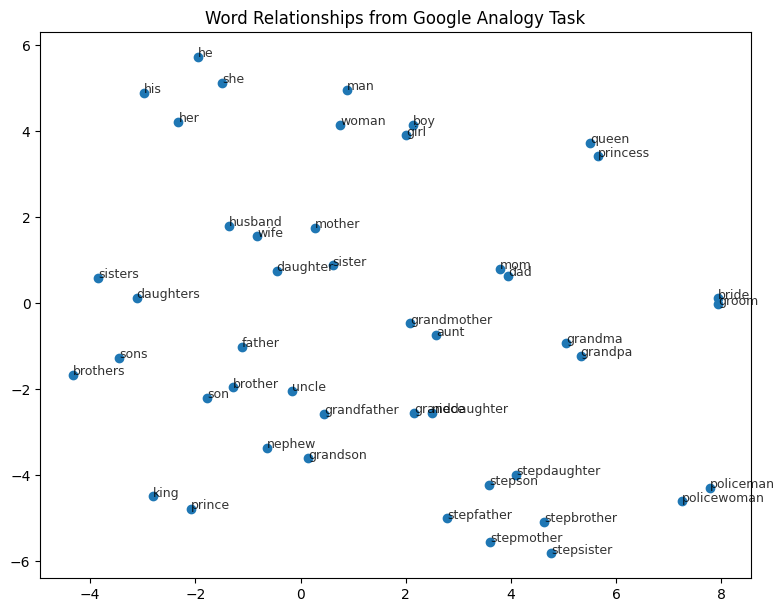

<Figure size 640x480 with 0 Axes>

In [16]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO3: Plot t-SNE for the words in the SUB_CATEGORY `: family`
subcat_name = SUB_CATEGORY.lstrip(":").strip()
mask = (
    data["SubCategory"].astype(str).str.strip().str.lstrip(":")
    == subcat_name
)
family_rows = data.loc[mask, "Question"]

# Collect unique words
words = set()
for q in family_rows:
    words.update(q.split())

# Keep only in-vocab words
key_index = getattr(model, "key_to_index", None)
if key_index is not None:
    in_vocab = sorted([w for w in words if w in key_index])
else:
    in_vocab = sorted([w for w in words if (w in getattr(model, "vocab", {})) or (w in model)])

if len(in_vocab) < 3:
    raise ValueError(f"Not enough in-vocab words (got {len(in_vocab)}).")

# Embed + t-SNE
vectors = np.vstack([model[w] for w in in_vocab])
n = len(in_vocab)
perp = max(5, min(30, n // 3, n - 1))
tsne = TSNE(n_components=2, perplexity=perp, learning_rate="auto",
            init="pca", random_state=42, n_iter=1000)
emb2d = tsne.fit_transform(vectors)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(emb2d[:, 0], emb2d[:, 1])
for i, w in enumerate(in_vocab):
    plt.annotate(w, (emb2d[i, 0], emb2d[i, 1]), fontsize=9, alpha=0.8)
plt.tight_layout()


plt.title("Word Relationships from Google Analogy Task")
plt.show()
plt.savefig("word_relationships.png", bbox_inches="tight")

### Part III: Train your own word embeddings

### Get the latest English Wikipedia articles and do sampling.
- Usually, we start from Wikipedia dump (https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2). However, the downloading step will take very long. Also, the cleaning step for the Wikipedia corpus ([`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus)) will take much time. Therefore, we provide cleaned files for you.

In [17]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles).
!gdown --id 1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd -O wiki_texts_part_0.txt.gz
!gdown --id 1ABblLRd9HXdXvaNv8H9fFq984bhnowoG -O wiki_texts_part_1.txt.gz
!gdown --id 1z2VFNhpPvCejTP5zyejzKj5YjI_Bn42M -O wiki_texts_part_2.txt.gz
!gdown --id 1VKjded9BxADRhIoCzXy_W8uzVOTWIf0g -O wiki_texts_part_3.txt.gz
!gdown --id 16mBeG26m9LzHXdPe8UrijUIc6sHxhknz -O wiki_texts_part_4.txt.gz

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd
From (redirected): https://drive.google.com/uc?id=1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd&confirm=t&uuid=7712cb15-fe4e-4fa2-9966-b4947f3c7179
To: /content/wiki_texts_part_0.txt.gz
100% 1.51G/1.51G [00:09<00:00, 165MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ABblLRd9HXdXvaNv8H9fFq984bhnowoG
From (redirected): https://drive.google.com/uc?id=1ABblLRd9HXdXvaNv8H9fFq984bhnowoG&confirm=t&uuid=4e660dce-8e0b-489f-8e60-0fd58a2ef31d
To: /content/w

In [18]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles), except the last file.
!gdown --id 17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI -O wiki_texts_part_5.txt.gz
!gdown --id 19IvB2vOJRGlrYulnTXlZECR8zT5v550P -O wiki_texts_part_6.txt.gz
!gdown --id 1sjwO8A2SDOKruv6-8NEq7pEIuQ50ygVV -O wiki_texts_part_7.txt.gz
!gdown --id 1s7xKWJmyk98Jbq6Fi1scrHy7fr_ellUX -O wiki_texts_part_8.txt.gz
!gdown --id 17eQXcrvY1cfpKelLbP2BhQKrljnFNykr -O wiki_texts_part_9.txt.gz
!gdown --id 1J5TAN6bNBiSgTIYiPwzmABvGhAF58h62 -O wiki_texts_part_10.txt.gz

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI
From (redirected): https://drive.google.com/uc?id=17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI&confirm=t&uuid=6ae70b90-6661-4ec3-9166-7a0e23dedabe
To: /content/wiki_texts_part_5.txt.gz
100% 578M/578M [00:08<00:00, 71.1MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19IvB2vOJRGlrYulnTXlZECR8zT5v550P
From (redirected): https://drive.google.com/uc?id=19IvB2vOJRGlrYulnTXlZECR8zT5v550P&confirm=t&uuid=62a219db-a687-456a-9817-8f4785b69d15
To: /content/wi

In [19]:
# Extract the downloaded wiki_texts_parts files.
!gunzip -k wiki_texts_part_*.gz

In [20]:
# Combine the extracted wiki_texts_parts files.
!cat wiki_texts_part_*.txt > wiki_texts_combined.txt

In [21]:
# Check the first ten lines of the combined file
!head -n 10 wiki_texts_combined.txt

anarchism is political philosophy and movement that is against all forms of authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy typically including the state and capitalism anarchism advocates for the replacement of the state with stateless societies and voluntary free associations as historically left wing movement this reading of anarchism is placed on the farthest left of the political spectrum usually described as the libertarian wing of the socialist movement libertarian socialism although traces of anarchist ideas are found all throughout history modern anarchism emerged from the enlightenment during the latter half of the th and the first decades of the th century the anarchist movement flourished in most parts of the world and had significant role in workers struggles for emancipation various anarchist schools of thought formed during this period anarchists have taken part in several revolutions most notably in the paris commune

Please note that we used the default parameters of [`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus) for cleaning the Wiki raw file. Thus, words with one character were discarded.

In [22]:
# Now you need to do sampling because the corpus is too big.
# You can further perform analysis with a greater sampling ratio.

import random

wiki_txt_path = "wiki_texts_combined.txt"
# wiki_texts_combined.txt is a text file separated by linebreaks (\n).
# Each row in wiki_texts_combined.txt indicates a Wikipedia article.
output_path = "wiki_sample_20.txt"

with open(wiki_txt_path, "r", encoding="utf-8") as f:
    with open(output_path, "w", encoding="utf-8") as output_file:
    # TODO4: Sample `20%` Wikipedia articles
    # Write your code here
      sampling_ratio = 0.20
      rng = random.Random(42)  # reproducible sampling
      total = kept = 0
      for line in f:
        total += 1
        if rng.random() < sampling_ratio:
          output_file.write(line)
          kept += 1
print(f"[sampling] kept {kept}/{total} ({(kept/total if total else 0):.2%}) → {output_path}")

[sampling] kept 1124733/5623655 (20.00%) → wiki_sample_20.txt


In [23]:
# TODO5: Train your own word embeddings with the sampled articles
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
# Hint: You should perform some pre-processing before training.

In [ ]:
import multiprocessing as mp
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

# Requires: output_path from TODO4 (e.g., "wiki_sample_20.txt")
class LineSentencePreprocessed:
    def __init__(self, path: str): self.path = path
    def __iter__(self):
        with open(self.path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if line:
                    # deacc=True removes punctuation; min_len=2 matches WikiCorpus behavior
                    yield simple_preprocess(line, deacc=True, min_len=2, max_len=20)

sentences = LineSentencePreprocessed(output_path)

w2v = Word2Vec(
    vector_size=100, window=5, min_count=2,  # lower min_count to improve coverage
    sg=1, negative=10, workers=mp.cpu_count(), seed=42
)
w2v.build_vocab(sentences)
w2v.train(sentences, total_examples=w2v.corpus_count, epochs=10)
w2v.save("wiki_w2v.model")
print(f"[train] vocab={len(w2v.wv):,} saved → wiki_w2v.model")

In [ ]:
data = pd.read_csv("questions-words.csv")

In [ ]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
      # TODO6: Write your code here to use your trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
    # Unpack: "a b c d"
      a, b, c, d = (t.lower() for t in analogy.split())
      golds.append(d)
      try:
        candidates = w2v.wv.most_similar(positive=[b, c], negative=[a], topn=10)
        pred = next((w for w, _ in candidates if w not in {a, b, c}), "")
      except KeyError:
        pred = ""
      preds.append(pred)

In [ ]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO7: Plot t-SNE for the words in the SUB_CATEGORY `: family`
subcat_name = SUB_CATEGORY.lstrip(":").strip()
mask = (data["SubCategory"].astype(str).str.strip().str.lstrip(":") == subcat_name)
family_rows = data.loc[mask, "Question"]

# 收集唯一單字
words = set()
for q in family_rows:
    words.update(q.split())

# 僅保留在詞彙表中的單字（trained.wv.key_to_index）
in_vocab = sorted([w for w in words if w in w2v.wv.key_to_index])
if len(in_vocab) < 3:
    raise ValueError(f"Not enough in-vocab words (got {len(in_vocab)}).")

# 取向量並做 t-SNE
vectors = np.vstack([w2v.wv[w] for w in in_vocab])
n = len(in_vocab)
perp = max(5, min(30, n // 3, n - 1))  # 與你 Part II 的計法一致
tsne = TSNE(n_components=2, perplexity=perp, learning_rate="auto",
            init="pca", random_state=42, n_iter=1000)
emb2d = tsne.fit_transform(vectors)

# 畫圖（保持同樣順序：title -> show -> savefig）
plt.figure(figsize=(8, 6))
plt.scatter(emb2d[:, 0], emb2d[:, 1])
for i, w in enumerate(in_vocab):
    plt.annotate(w, (emb2d[i, 0], emb2d[i, 1]), fontsize=9, alpha=0.8)
plt.tight_layout()

plt.title("Word Relationships from Google Analogy Task")
plt.show()
plt.savefig("word_relationships.png", bbox_inches="tight")